#The notebook contains nlp model model on sentiment analysis of financial news and company.

--- The data contains sentiment of financial news headline from the perspective of retail investors.---

Exploratory Data analysis


In [ ]:
!pip install tensorflow


In [ ]:
!pip install wordcloud

     ------------------------------------ 152.1/152.1 kB 378.3 kB/s eta 0:00:00


In [1]:
#importing the required libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from gensim.utils import simple_preprocess
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.models import Model
import gensim.downloader as api
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, Sequential

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [10]:
#The data recides in the google drive directory
# mounting the drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading the data

In [11]:
# reading the training data and printing the first five rows
df= pd.read_csv('gdrive/My Drive/financial_news_data.csv',delimiter=',', encoding_errors='ignore')
df.head()

,positive,"Consolidated net sales increased 16 % to reach EUR74 .8 m , while operating profit amounted to EUR0 .9 m compared to a loss of EUR0 .7 m in the prior year period ."
0,positve,Clothing retail chain Sepp+l+ 's sales increas...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [12]:
# Setting the data columns
df.columns= ['sentiment','News']

In [13]:
#printing sample of the data
df.head()

,sentiment,News
0,positve,Clothing retail chain Sepp+l+ 's sales increas...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [14]:
df.isnull().sum()

sentiment    0
News         0
dtype: int64

In [15]:
df.dtypes

sentiment    object
News         object
dtype: object

In [16]:
print('There are {} rows and {} columns in train_df'.format(df.shape[0],df.shape[1]))


There are 4845 rows and 2 columns in train_df


In [17]:
#Removing the neutral labels 
df = df[df.sentiment != "neutral"]
df.head()

,sentiment,News
0,positve,Clothing retail chain Sepp+l+ 's sales increas...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [18]:
#printing data category in the target
df['sentiment'].value_counts()

positive    1363
negative     604
positve        1
Name: sentiment, dtype: int64

In [19]:
# Correcting the mispelt class
df['sentiment']=df['sentiment'].replace('positve',"positive")

In [20]:
df['sentiment'].value_counts()

positive    1364
negative     604
Name: sentiment, dtype: int64

(array([0, 1]), [Text(0, 0, 'positive'), Text(1, 0, 'negative')])

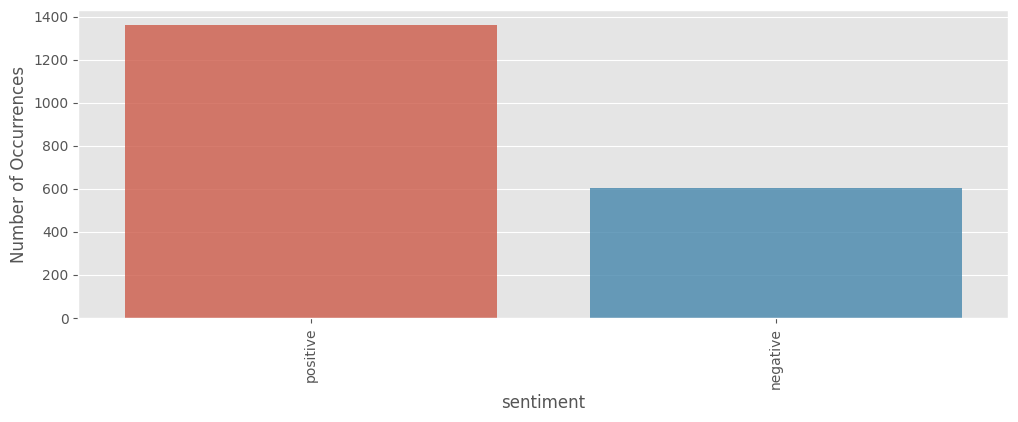

In [21]:
sentiment=df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)

Number of characters in News

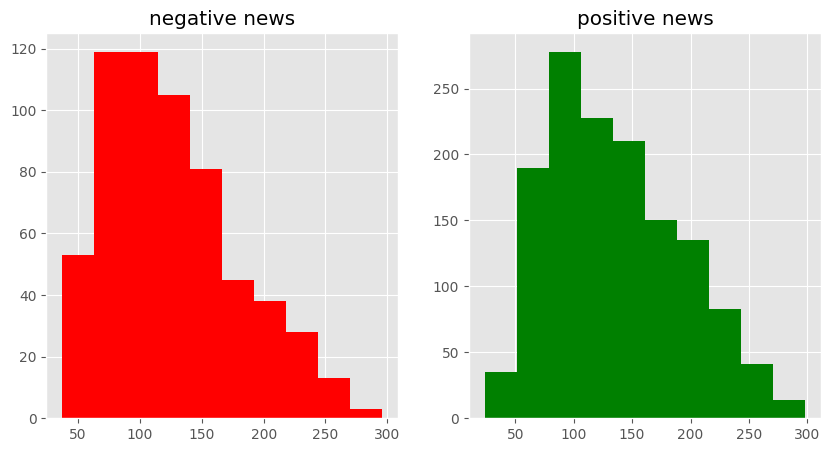

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
num_characters=df[df['sentiment']=='negative']['News'].str.len()
ax1.hist(num_characters,color='red')
ax1.set_title('negative news')
num_characters=df[df['sentiment']=='positive']['News'].str.len()
ax2.hist(num_characters,color='green')
ax2.set_title('positive news')
plt.show()

There are more characters between 70-160 in positive news compared to negative news 

Number of words in a News

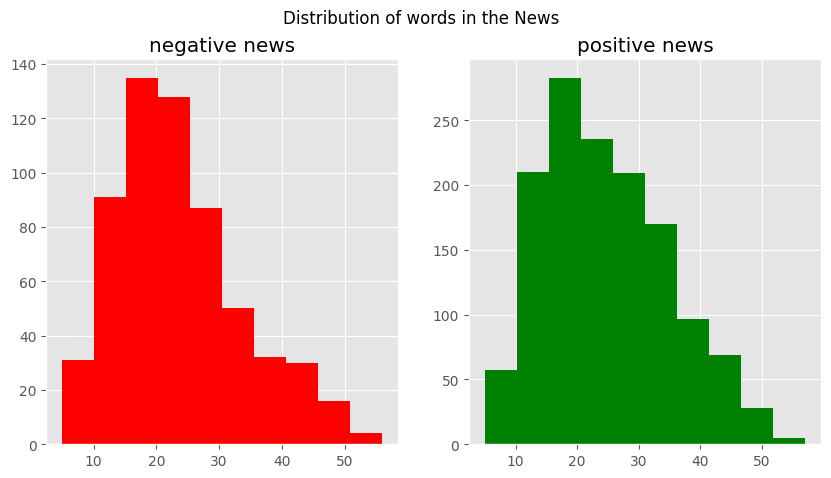

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
num_words=df[df['sentiment']=='negative']['News'].str.split().map(lambda x: len(x))
ax1.hist(num_words,color='red')
ax1.set_title('negative news')
num_words=df[df['sentiment']=='positive']['News'].str.split().map(lambda x: len(x))
ax2.hist(num_words,color='green')
ax2.set_title('positive news')
fig.suptitle('Distribution of words in the News')
plt.show()

In [24]:
def create_corpus(sentiment):
    """ List of words in the News"""
    words_list=[]
    
    for x in df[df['sentiment']==sentiment]['News'].str.split():
        for i in x:
            words_list.append(i)
    return words_list

In [25]:
words_list = create_corpus('negative')
print(words_list[:100])



['The', 'international', 'electronic', 'industry', 'company', 'Elcoteq', 'has', 'laid', 'off', 'tens', 'of', 'employees', 'from', 'its', 'Tallinn', 'facility', ';', 'contrary', 'to', 'earlier', 'layoffs', 'the', 'company', 'contracted', 'the', 'ranks', 'of', 'its', 'office', 'workers', ',', 'the', 'daily', 'Postimees', 'reported', '.', 'A', 'tinyurl', 'link', 'takes', 'users', 'to', 'a', 'scamming', 'site', 'promising', 'that', 'users', 'can', 'earn', 'thousands', 'of', 'dollars', 'by', 'becoming', 'a', 'Google', '(', 'NASDAQ', ':', 'GOOG', ')', 'Cash', 'advertiser', '.', 'Compared', 'with', 'the', 'FTSE', '100', 'index', ',', 'which', 'rose', '36.7', 'points', '(', 'or', '0.6', '%', ')', 'on', 'the', 'day', ',', 'this', 'was', 'a', 'relative', 'price', 'change', 'of', '-0.2', '%', '.', 'Compared', 'with', 'the', 'FTSE', '100']


Visualising the stop words in positive news


In [26]:
#stop words count 
import nltk
nltk.download('stopwords')
dic=defaultdict(int)
stop = set(stopwords.words("english"))
for word in words_list:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<BarContainer object of 10 artists>

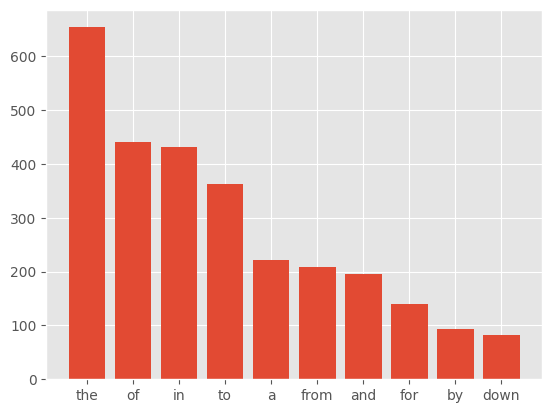

In [27]:
x,y=zip(*top)
plt.bar(x,y)

Visualising stop words in negative  news 

In [28]:
words_list_1 = create_corpus('negative')

In [29]:
dic=defaultdict(int)
stop = set(stopwords.words("english"))

for word in words_list_1:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

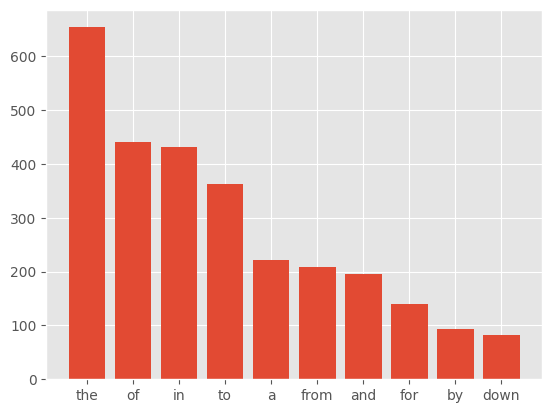

In [30]:
x,y=zip(*top)
plt.bar(x,y)

Analysing punctuations

<BarContainer object of 13 artists>

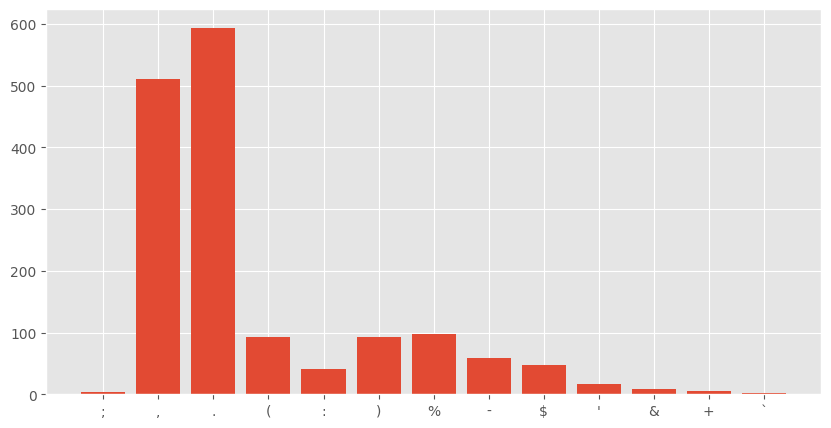

In [31]:
# punctuations in negative news
plt.figure(figsize=(10,5))
word_lists=create_corpus('negative')

dic=defaultdict(int)
import string
special = string.punctuation
for i in (words_list):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 13 artists>

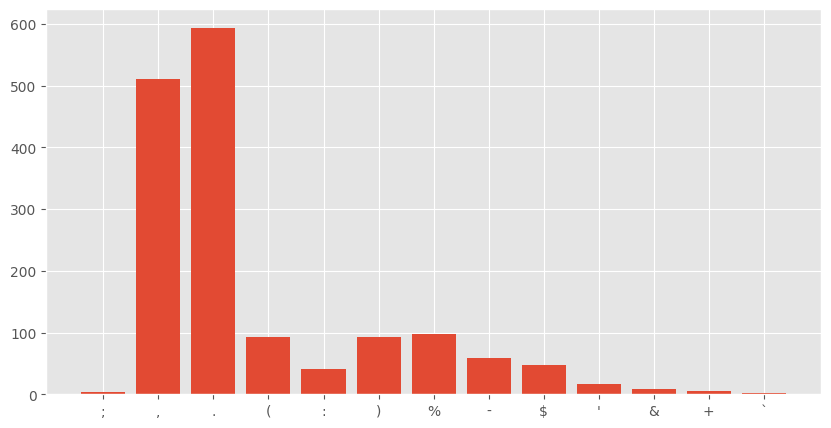

In [32]:
# punctuations in positive news
plt.figure(figsize=(10,5))
word_lists=create_corpus('positive')

dic=defaultdict(int)
import string
special = string.punctuation
for i in (words_list):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

Ngram analysis (checking the most common 2 letter words(N =2) in the News)


In [33]:
def most_common_2_letter_words(words_list, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(words_list)
    bag_of_words = vec.transform(words_list)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

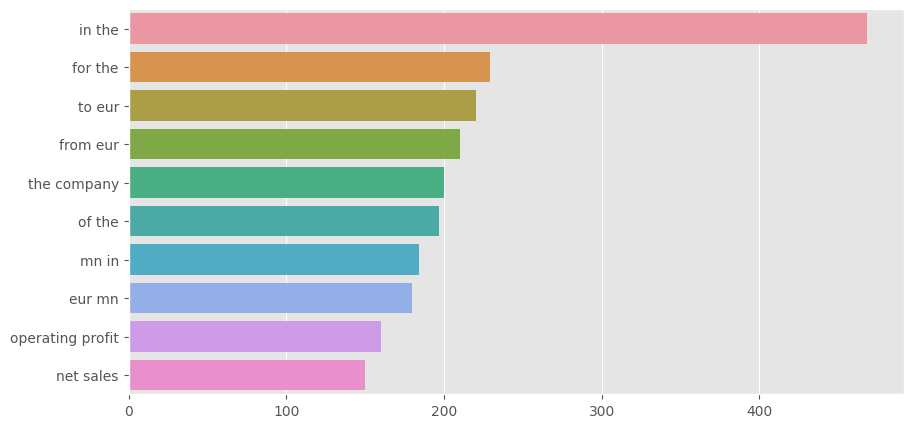

In [34]:
plt.figure(figsize=(10,5))
bigrams=most_common_2_letter_words(df['News'])[:10]
x,y=map(list,zip(*bigrams))
sns.barplot(x=y,y=x)

visualising the keywords in the News




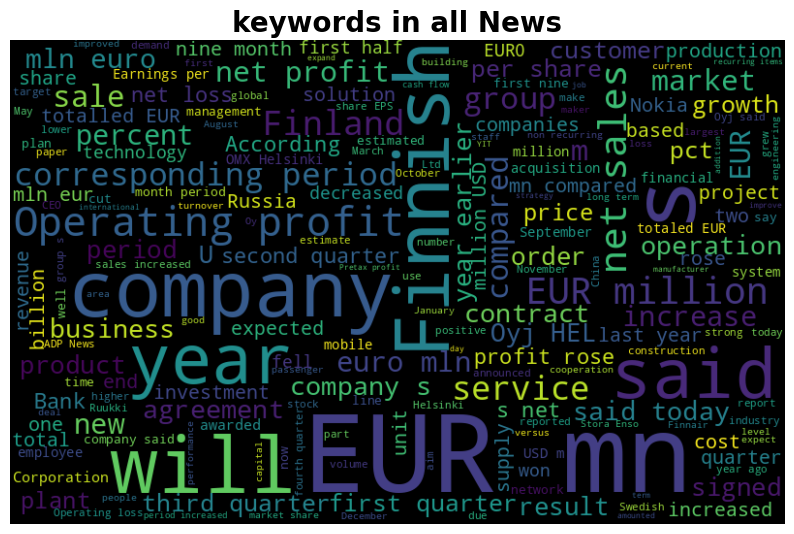

In [35]:
# getting all the keywords from the News
key_News = " ".join([word for word in df["News"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(key_News)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("keywords in all News", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

keywords in positive news

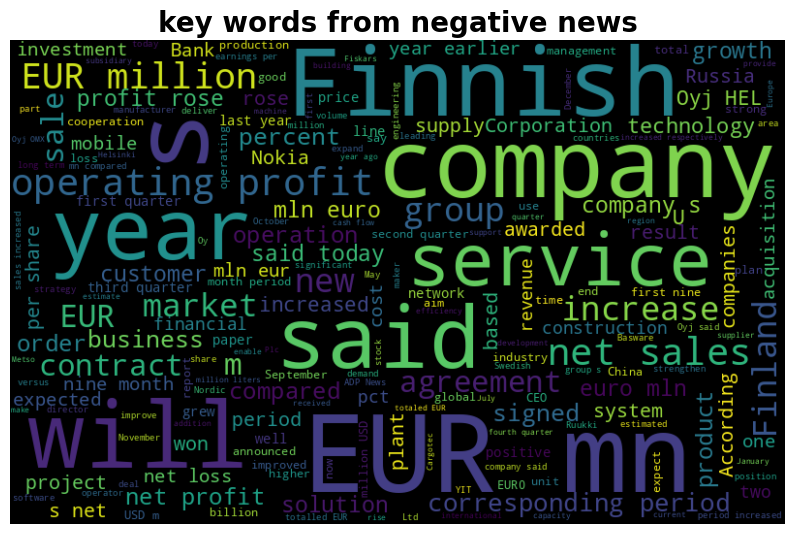

In [36]:
key_negative_news = " ".join([word for word in df[df["sentiment"]=='positive']["News"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(key_negative_news)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("key words from negative news", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

keyword from positive news

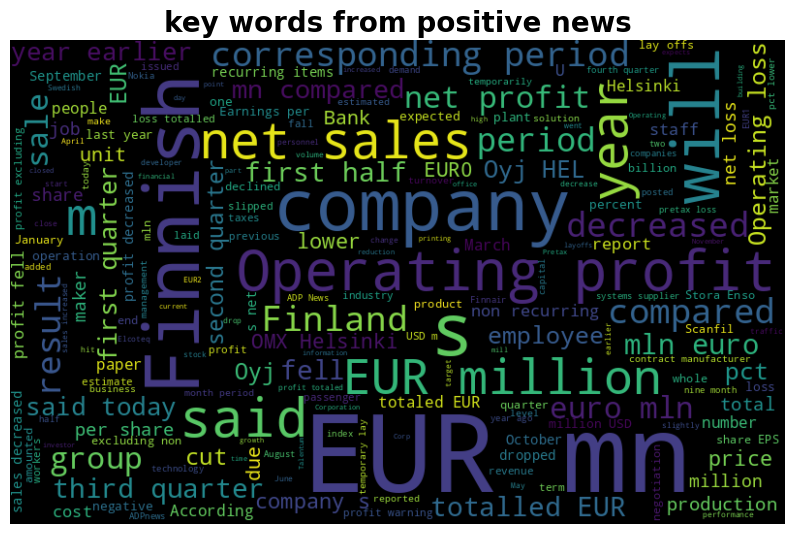

In [37]:
key_positive_news= " ".join([word for word in df[df["sentiment"]=='negative']["News"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(key_positive_news)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("key words from positive news", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Models


Deep Learning Models

#Model 1 : SIMPLE RNN (Base Model)

In [38]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [39]:
data = df['News'].map(word_tokenize).values
total_vocabulary = set(word.lower() for News in data for word in News)  # set created from nested comprehension 
print('There are {} unique words in the dataset.'.format(len(total_vocabulary)))
print('There are {} unique News in the dataset.'.format(len(data)))

# Hyperparameters
vocab= len(total_vocabulary)
max_sentence_length = 210
embedding_vector_length = 100
dropout = 0.5
trunc_type= 'post'


# Tokenising to change the text to characters
tokenizer = Tokenizer(num_words = vocab)
tokenizer.fit_on_texts(df['News'].values)
sequences = tokenizer.texts_to_sequences(df['News'].values)
word_index = tokenizer.word_index
print(word_index)


There are 6456 unique words in the dataset.
There are 1968 unique News in the dataset.
{'the': 1, 'in': 2, 'of': 3, 'to': 4, 'and': 5, 'eur': 6, 'a': 7, 'from': 8, 'for': 9, 'mn': 10, "'s": 11, 'profit': 12, 'company': 13, 'its': 14, 'year': 15, 'said': 16, 'finnish': 17, '1': 18, 'net': 19, 'sales': 20, 'by': 21, 'on': 22, 'has': 23, 'will': 24, 'million': 25, 'with': 26, '2': 27, 'period': 28, '5': 29, 'm': 30, '3': 31, 'operating': 32, 'it': 33, 'is': 34, 'quarter': 35, '0': 36, 'mln': 37, '2009': 38, '4': 39, 'that': 40, 'at': 41, 'as': 42, '6': 43, 'was': 44, '2008': 45, '8': 46, '7': 47, '9': 48, '2010': 49, 'oyj': 50, '2007': 51, 'loss': 52, 'be': 53, 'compared': 54, 'group': 55, 'first': 56, 'an': 57, 'finland': 58, 'up': 59, "''": 60, 'corresponding': 61, 'increased': 62, 'euro': 63, 'rose': 64, '2006': 65, 'share': 66, 'are': 67, 'have': 68, 'today': 69, 'market': 70, 'new': 71, '000': 72, 'percent': 73, 'which': 74, 'down': 75, 'also': 76, 'hel': 77, 'per': 78, '2005': 79, '

Encoding the label to change it from vategorical to numeric feature

In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0
df['sentiment'] = le.fit_transform(df['sentiment'])

In [41]:
# padding to make the sentence equal to our set maximum sentence length if less than it

padded = pad_sequences(sequences, maxlen= max_sentence_length, truncating = trunc_type)
X_train, X_test, y_train, y_test = train_test_split(padded, df['sentiment'].values, test_size=0.2)



In [42]:
# Create the model
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN,GlobalMaxPool1D

model = Sequential()
    
model.add(Embedding(vocab, embedding_vector_length, input_length=max_sentence_length))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 210, 100)          645600    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 649,889
Trainable params: 649,889
Non-trainable params: 0
_________________________________________________________________


In [43]:
#compiling the model
model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])

In [44]:
history=model.fit(X_train,y_train,batch_size=10,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
158/158 - 15s - loss: 0.6085 - accuracy: 0.6982 - val_loss: 0.6098 - val_accuracy: 0.6929 - 15s/epoch - 92ms/step
Epoch 2/15
158/158 - 11s - loss: 0.3111 - accuracy: 0.8856 - val_loss: 0.4837 - val_accuracy: 0.7995 - 11s/epoch - 68ms/step
Epoch 3/15
158/158 - 10s - loss: 0.0692 - accuracy: 0.9816 - val_loss: 0.4346 - val_accuracy: 0.8223 - 10s/epoch - 66ms/step
Epoch 4/15
158/158 - 9s - loss: 0.0206 - accuracy: 0.9987 - val_loss: 0.5199 - val_accuracy: 0.7817 - 9s/epoch - 54ms/step
Epoch 5/15
158/158 - 11s - loss: 0.0162 - accuracy: 0.9962 - val_loss: 0.5576 - val_accuracy: 0.7792 - 11s/epoch - 68ms/step
Epoch 6/15
158/158 - 11s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.5397 - val_accuracy: 0.8173 - 11s/epoch - 67ms/step
Epoch 7/15
158/158 - 9s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.5006 - val_accuracy: 0.8503 - 9s/epoch - 54ms/step
Epoch 8/15
158/158 - 11s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4927 - val_accuracy: 0.8325 - 11s/epoch - 68ms/step
Epoc

In [45]:
history_1 = pd.DataFrame(history.history)
history_1

,loss,accuracy,val_loss,val_accuracy
0,0.608482,0.698221,0.609781,0.692893
1,0.311116,0.885642,0.483661,0.799492
2,0.069165,0.981576,0.434560,0.822335
3,0.020617,0.998729,0.519886,0.781726
4,0.016189,0.996188,0.557582,0.779188
5,0.005240,1.000000,0.539750,0.817259
6,0.002701,1.000000,0.500562,0.850254
7,0.001788,1.000000,0.492706,0.832487
8,0.001354,1.000000,0.529474,0.852792
9,0.001017,1.000000,0.527305,0.852792


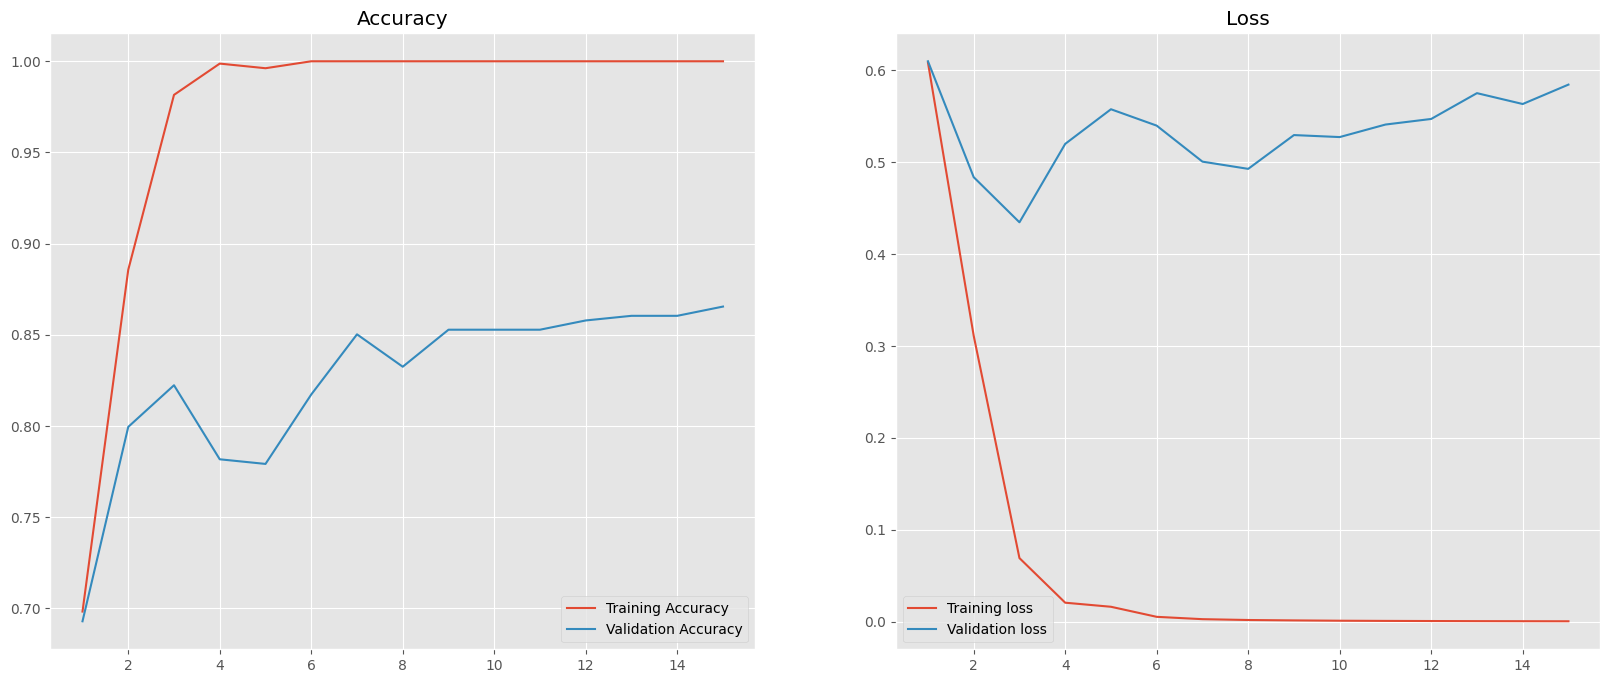

In [46]:
epoch = range(1,  len(history_1)+1)
plt.figure(figsize = (20,8))

plt.subplot(121)
plt.title('Accuracy')
plt.plot(epoch, history_1['accuracy'], label = 'Training Accuracy')
plt.plot(epoch, history_1['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot(epoch, history_1['loss'], label = 'Training loss')
plt.plot(epoch, history_1['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

EVALUATION

13/13 [==============================] - 0s 14ms/step
[0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 

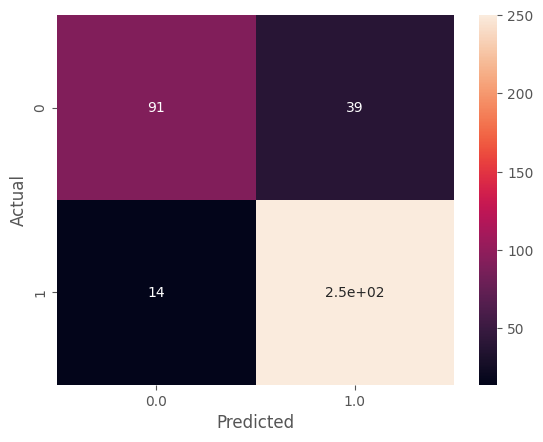

In [47]:
from tensorflow.python.util.nest import flatten
y_pred = model.predict(X_test)
cutoff = 0.5                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
 
y_pred_classes = y_pred_classes.flatten()
print(y_pred_classes)



confusion_matrix = pd.crosstab(y_test,y_pred_classes, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [48]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print('The accuracy of simpleRNN Bayes Model :  ', accuracy )

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of SimpleRNN Model :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of simpleRNN Model :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)

print('The f1_score of simpleRNN Model :  ', f1_score )

The accuracy of simpleRNN Bayes Model :   0.8654822335025381
The recall of SimpleRNN Model :   0.946969696969697
The precision of simpleRNN Model :   0.8650519031141869
The f1_score of simpleRNN Model :   0.9041591320072332


#Model 2: LSTM

In [ ]:
# Create the model
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN

model_2 = Sequential()
    
model_2.add(Embedding(vocab, embedding_vector_length, input_length=max_sentence_length))
model_2.add(LSTM(32, dropout=dropout, recurrent_dropout=dropout)),
model_2.add(Dense(1, activation='sigmoid'))
model_2.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 210, 100)          645600    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 662,657
Trainable params: 662,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#compiling the model

model_2.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])

In [ ]:
history=model_2.fit(X_train,y_train,batch_size=10,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
158/158 - 51s - loss: 0.6134 - accuracy: 0.6830 - val_loss: 0.4808 - val_accuracy: 0.7665 - 51s/epoch - 326ms/step
Epoch 2/15
158/158 - 45s - loss: 0.3432 - accuracy: 0.8704 - val_loss: 0.3430 - val_accuracy: 0.8452 - 45s/epoch - 284ms/step
Epoch 3/15
158/158 - 45s - loss: 0.1719 - accuracy: 0.9441 - val_loss: 0.4668 - val_accuracy: 0.7665 - 45s/epoch - 283ms/step
Epoch 4/15
158/158 - 48s - loss: 0.0959 - accuracy: 0.9701 - val_loss: 0.3350 - val_accuracy: 0.8985 - 48s/epoch - 301ms/step
Epoch 5/15
158/158 - 46s - loss: 0.0629 - accuracy: 0.9816 - val_loss: 0.3252 - val_accuracy: 0.8832 - 46s/epoch - 292ms/step
Epoch 6/15
158/158 - 45s - loss: 0.0517 - accuracy: 0.9841 - val_loss: 0.2922 - val_accuracy: 0.8909 - 45s/epoch - 285ms/step
Epoch 7/15
158/158 - 47s - loss: 0.0363 - accuracy: 0.9905 - val_loss: 0.3814 - val_accuracy: 0.8883 - 47s/epoch - 298ms/step
Epoch 8/15
158/158 - 45s - loss: 0.0289 - accuracy: 0.9930 - val_loss: 0.3455 - val_accuracy: 0.8934 - 45s/epoch - 285

In [ ]:
history_2 = pd.DataFrame(history.history)
history_2

,loss,accuracy,val_loss,val_accuracy
0,0.613405,0.682973,0.480838,0.766497
1,0.343197,0.870394,0.342966,0.845178
2,0.171936,0.944091,0.466767,0.766497
3,0.095866,0.970140,0.335013,0.898477
4,0.062913,0.981576,0.325195,0.883249
5,0.051670,0.984117,0.292163,0.890863
6,0.036268,0.990470,0.381424,0.888325
7,0.028858,0.993011,0.345528,0.893401
8,0.031353,0.990470,0.366533,0.890863
9,0.030753,0.989835,0.348766,0.893401


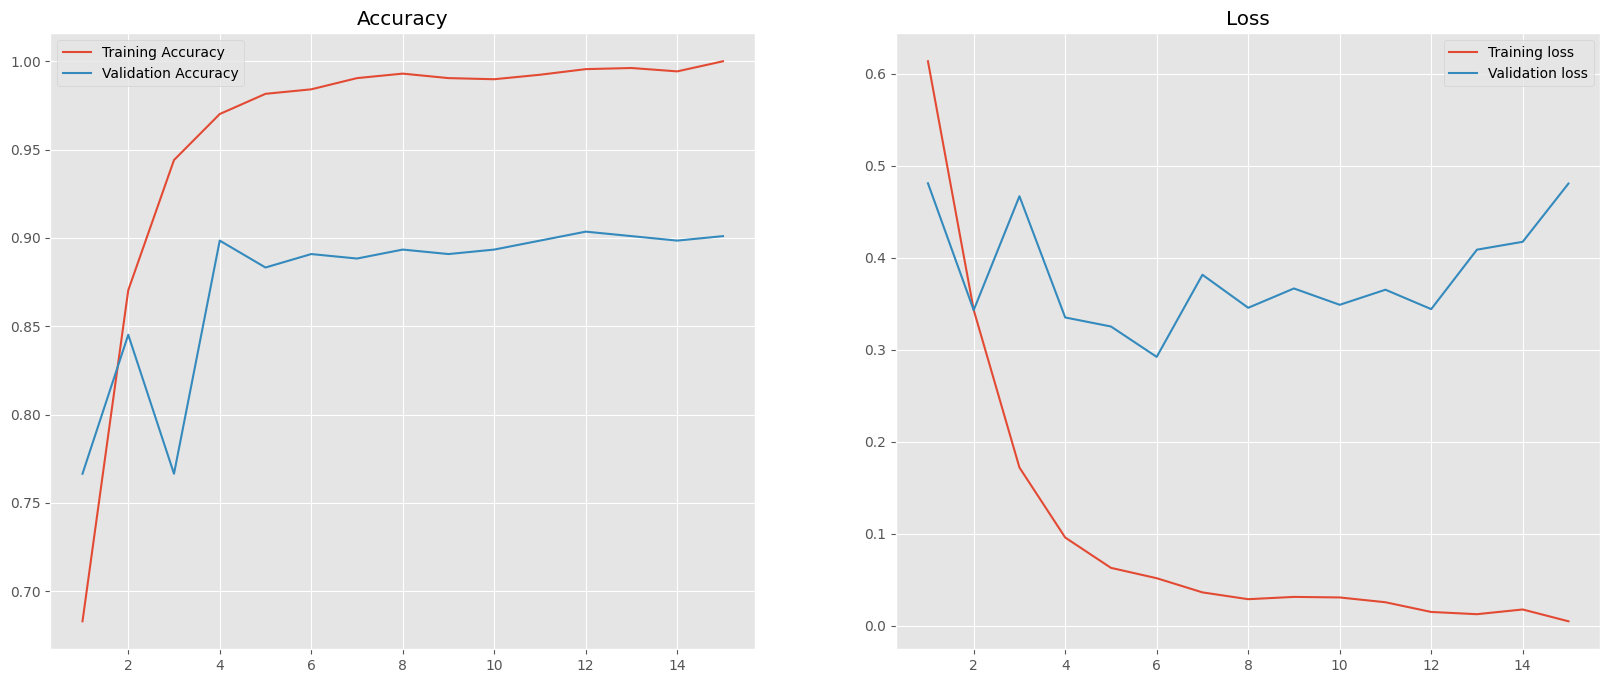

In [ ]:
epoch = range(1,  len(history_2)+1)
plt.figure(figsize = (20,8))

plt.subplot(121)
plt.title('Accuracy')
plt.plot(epoch, history_2['accuracy'], label = 'Training Accuracy')
plt.plot(epoch, history_2['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot(epoch, history_2['loss'], label = 'Training loss')
plt.plot(epoch, history_2['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

Evaluation

13/13 [==============================] - 1s 64ms/step
[1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 

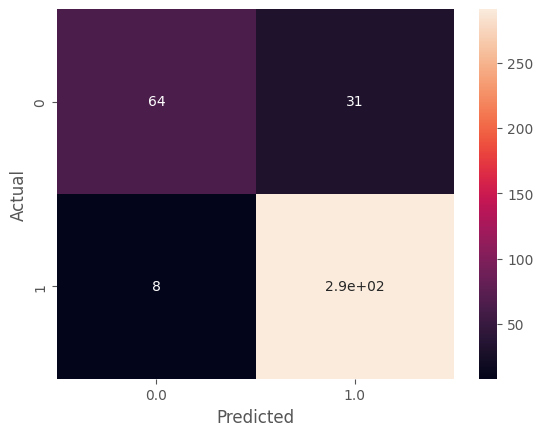

In [ ]:
from tensorflow.python.util.nest import flatten
y_pred = model_2.predict(X_test)
cutoff = 0.5                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
 
y_pred_classes = y_pred_classes.flatten()
print(y_pred_classes)



confusion_matrix = pd.crosstab(y_test,y_pred_classes, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print('The accuracy of LSTM Model :  ', accuracy )

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of LSTM Model :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of LSTM Model :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)

print('The f1_score of LSTM Model :  ', f1_score )

The accuracy of LSTM Model :   0.9010152284263959
The recall of LSTM Model :   0.9732441471571907
The precision of LSTM Model :   0.9037267080745341
The f1_score of LSTM Model :   0.9371980676328502


#Model3 : Bidirectional LSTM

In [ ]:

# Create the model
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN

model_3 = Sequential()
    
model_3.add(Embedding(vocab, embedding_vector_length, input_length=max_sentence_length))
model_3.add(Bidirectional(LSTM(32, dropout=dropout, recurrent_dropout=dropout))),
model_3.add(Dense(1, activation='sigmoid'))
model_3.summary()

model_3.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 210, 100)          645600    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               34048     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 679,713
Trainable params: 679,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model_3.fit(X_train,y_train,batch_size=10,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
158/158 - 93s - loss: 0.6281 - accuracy: 0.6925 - val_loss: 0.8406 - val_accuracy: 0.7589 - 93s/epoch - 589ms/step
Epoch 2/15
158/158 - 84s - loss: 0.4503 - accuracy: 0.8266 - val_loss: 0.3509 - val_accuracy: 0.8503 - 84s/epoch - 529ms/step
Epoch 3/15
158/158 - 81s - loss: 0.2141 - accuracy: 0.9384 - val_loss: 0.3376 - val_accuracy: 0.8629 - 81s/epoch - 511ms/step
Epoch 4/15
158/158 - 85s - loss: 0.1388 - accuracy: 0.9581 - val_loss: 0.5272 - val_accuracy: 0.8046 - 85s/epoch - 540ms/step
Epoch 5/15
158/158 - 81s - loss: 0.0940 - accuracy: 0.9727 - val_loss: 0.2960 - val_accuracy: 0.8731 - 81s/epoch - 512ms/step
Epoch 6/15
158/158 - 82s - loss: 0.0678 - accuracy: 0.9822 - val_loss: 0.3301 - val_accuracy: 0.9010 - 82s/epoch - 520ms/step
Epoch 7/15
158/158 - 85s - loss: 0.0495 - accuracy: 0.9860 - val_loss: 0.3612 - val_accuracy: 0.8832 - 85s/epoch - 535ms/step
Epoch 8/15
158/158 - 81s - loss: 0.0264 - accuracy: 0.9917 - val_loss: 0.3085 - val_accuracy: 0.9112 - 81s/epoch - 512

13/13 [==============================] - 2s 118ms/step
[1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.

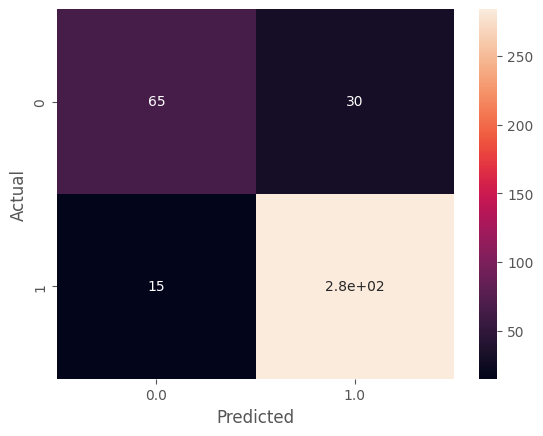

In [ ]:
from tensorflow.python.util.nest import flatten
y_pred = model_3.predict(X_test)
cutoff = 0.5                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
 
y_pred_classes = y_pred_classes.flatten()
print(y_pred_classes)



confusion_matrix = pd.crosstab(y_test,y_pred_classes, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print('The accuracy of Bi_LSTM Model :  ', accuracy )

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of Bi_LSTM Model :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of Bi_LSTM Model :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)
print('The f1_score of Bi_LSTM Model :  ',f1_score  )


The accuracy of Bi_LSTM Model :   0.8857868020304569
The recall of Bi_LSTM Model :   0.9498327759197325
The precision of Bi_LSTM Model :   0.9044585987261147
The f1_score of Bi_LSTM Model :   0.9265905383360522


#Model 4: Gated Recurrent Unit

In [ ]:
# Create the model
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU,SimpleRNN

model_4 = Sequential()
    
model_4.add(Embedding(vocab, embedding_vector_length, input_length=max_sentence_length))
model_4.add(GRU(64, dropout=dropout, recurrent_dropout=dropout)),
model_4.add(Dense(1, activation='sigmoid'))
model_4.summary()

model_4.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 210, 100)          645600    
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 677,537
Trainable params: 677,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model_4.fit(X_train,y_train,batch_size=10,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
158/158 - 59s - loss: 0.6107 - accuracy: 0.6925 - val_loss: 0.5594 - val_accuracy: 0.6878 - 59s/epoch - 374ms/step
Epoch 2/15
158/158 - 52s - loss: 0.3861 - accuracy: 0.8285 - val_loss: 0.3572 - val_accuracy: 0.8299 - 52s/epoch - 331ms/step
Epoch 3/15
158/158 - 50s - loss: 0.2219 - accuracy: 0.9187 - val_loss: 0.3978 - val_accuracy: 0.8376 - 50s/epoch - 315ms/step
Epoch 4/15
158/158 - 48s - loss: 0.1176 - accuracy: 0.9562 - val_loss: 0.4234 - val_accuracy: 0.8452 - 48s/epoch - 303ms/step
Epoch 5/15
158/158 - 48s - loss: 0.0863 - accuracy: 0.9695 - val_loss: 0.4168 - val_accuracy: 0.8477 - 48s/epoch - 301ms/step
Epoch 6/15
158/158 - 48s - loss: 0.0534 - accuracy: 0.9816 - val_loss: 0.4491 - val_accuracy: 0.8553 - 48s/epoch - 301ms/step
Epoch 7/15
158/158 - 47s - loss: 0.0354 - accuracy: 0.9873 - val_loss: 0.5463 - val_accuracy: 0.8528 - 47s/epoch - 298ms/step
Epoch 8/15
158/158 - 48s - loss: 0.0361 - accuracy: 0.9879 - val_loss: 0.5167 - val_accuracy: 0.8426 - 48s/epoch - 302

In [ ]:
history_4 = pd.DataFrame(history.history)
history_4

,loss,accuracy,val_loss,val_accuracy
0,0.610728,0.692503,0.559355,0.687817
1,0.386068,0.828463,0.357183,0.829949
2,0.221894,0.918679,0.397839,0.837563
3,0.117645,0.956163,0.423377,0.845178
4,0.086306,0.969504,0.416826,0.847716
5,0.053408,0.981576,0.449059,0.855330
6,0.035448,0.987294,0.546295,0.852792
7,0.036116,0.987929,0.516701,0.842640
8,0.030892,0.993011,0.531533,0.850254
9,0.012803,0.996188,0.560255,0.855330


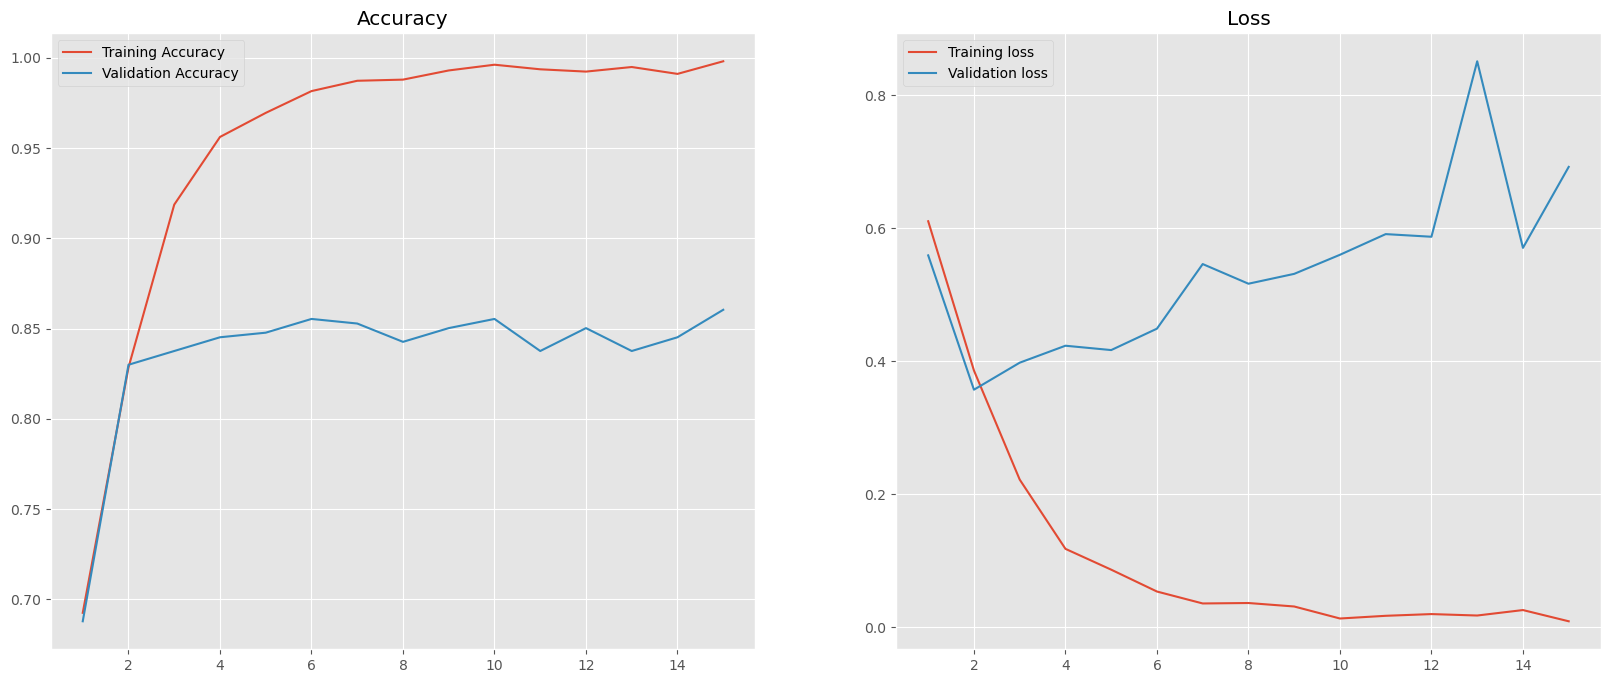

In [ ]:
epoch = range(1,  len(history_4)+1)
plt.figure(figsize = (20,8))

plt.subplot(121)
plt.title('Accuracy')
plt.plot(epoch, history_4['accuracy'], label = 'Training Accuracy')
plt.plot(epoch, history_4['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot(epoch, history_4['loss'], label = 'Training loss')
plt.plot(epoch, history_4['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

13/13 [==============================] - 1s 36ms/step
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 

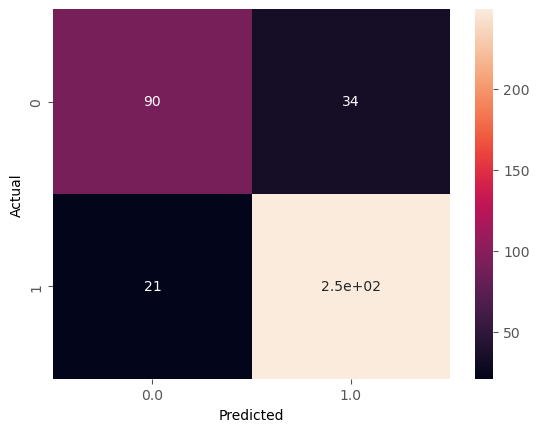

In [ ]:
from tensorflow.python.util.nest import flatten
y_pred = model_4.predict(X_test)
cutoff = 0.5                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
 
y_pred_classes = y_pred_classes.flatten()
print(y_pred_classes)



confusion_matrix = pd.crosstab(y_test,y_pred_classes, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_classes)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_classes)
print('The accuracy of GRU Model :  ', accuracy )

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_classes)
print('The recall of GRU Model :  ', recall )

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_classes)

print('The precision of GRUModel :  ', precision )

# f1_score
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred_classes)
print('The f1_score of GRU Model :  ',f1_score  )

The accuracy of GRU Model :   0.8604060913705583
The recall of GRU Model :   0.9222222222222223
The precision of GRUModel :   0.8798586572438163
The f1_score of GRU Model :   0.9005424954792043


# Model_4  GRU Model will be deployed based on having the highest metrics on accuracy , recall,precision and f1 score

##Saving the model as pickle file 

In [ ]:
import pickle 
pickle.dump(model_4,open('model.pickle','wb'))